In [75]:
LANDMARK_MODEL = "landmark"
VISUAL_MODEL = "visual"
COMBINED_MODEL = "combined"

model_type = COMBINED_MODEL

In [45]:
model_num = 8
preprocess_data = True

# Dependencies

In [7]:
import numpy as np
import pandas as pd
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
import re
import ast
import sys
import cv2
import random
import json

!pip install num2words

from jiwer import wer

## CSF
proj_data_dir = "../../proj_data/batches_both"
proj_model_dir = "../../proj_models/"



## Personal
# proj_data_dir = "D:/USB/data_gen_6/"


proj_code_dir = "../classes"
sys.path.append(proj_code_dir)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, LSTM, TimeDistributed,Bidirectional, InputLayer,Attention,Dense,Dropout,Input,Embedding,MultiHeadAttention,LayerNormalization, Concatenate, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import classification_report

!pip install datasets
from datasets import Dataset

2024-02-19 10:21:07.640053: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 10:21:22.951507: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 10:21:22.963854: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 10:22:04.069036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


  Using cached https://files.pythonhosted.org/packages/d3/95/ef83542e7a8e2bfc4432ee2cd8a6b52eb30fb1e605871e8871e94ce65fb1/datasets-2.13.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c5/68/d3410e975bebbf5be00c1238d0418345d8ec5d88b7a6c102211a1c967edd/pyarrow-12.0.1.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/bd/64/f0d369ede0ca54fdd520bdee5086dbaf0af81dac53a2ce847bd1ec6e0bf1/fsspec-2023.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/be/e3/a84bf2e561beed15813080d693b4b27573262433fced9c1d1fea59e60553/dill-0.3.6-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/3f/8354ce12fd13bd5c5bb4722261a10ca1d6e2eb7c1c08fa3d8a4e9dc98f44/multiprocess-0.70.15-py37-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7f/c4/adcbe9a696c135578cabcbdd7331332daad4d49b7c43688b

Failed to build pyarrow
ERROR: Could not build wheels for pyarrow which use PEP 517 and cannot be installed directly


/mnt/iusers01/fse-ugpgt01/compsci01/h61781jp/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Data

In [47]:
data_mat = loadmat(os.path.join(proj_data_dir, "split_large_test.mat"))

In [48]:
train_X_frames = data_mat["train_data_frames"]
train_X_landmarks = data_mat["train_data_keypoints"]
train_Y = data_mat["train_labels"]


test_X_frames = data_mat["test_data_frames"]
test_X_landmarks = data_mat["test_data_keypoints"]
test_Y = data_mat["test_labels"]

val_X_frames = data_mat["val_data_frames"]
val_X_landmarks = data_mat["val_data_keypoints"]
val_Y = data_mat["val_labels"]

In [49]:
def show_data():
    print(f"Train data frames length: {np.shape(train_X_frames)}")
    print(f"Train data landmarks length: {np.shape(train_X_landmarks)}")
    print(f"Train labels length: {np.shape(train_Y)}")

    print(f"Test data frames length: {np.shape(test_X_frames)}")
    print(f"Test data landmarks length: {np.shape(test_X_landmarks)}")
    print(f"Test labels length: {np.shape(test_Y)}")

    print(f"Validation data frames length: {np.shape(val_X_frames)}")
    print(f"Validation data landmarks length: {np.shape(val_X_landmarks)}")
    print(f"Validation labels length: {np.shape(val_Y)}")

In [50]:
show_data()

Train data frames length: (4393, 29, 100, 100)
Train data landmarks length: (4393, 29, 40, 3)
Train labels length: (4393,)
Test data frames length: (549, 29, 100, 100)
Test data landmarks length: (549, 29, 40, 3)
Test labels length: (549,)
Validation data frames length: (549, 29, 100, 100)
Validation data landmarks length: (549, 29, 40, 3)
Validation labels length: (549,)


## Prune Data
Remove some frames of the data: some frames include other words

In [51]:
prune_begin = 4
prune_end = 4

In [52]:
def prune_data(data, before: int, after: int):
    new_data = []
    for batch in data:
        batch_length = len(batch)
        new_data.append(batch[before:(batch_length-after)])
    print(np.shape(new_data))
    return new_data

In [53]:
train_X_frames = prune_data(data=train_X_frames, before=prune_begin, after=prune_end)
test_X_frames = prune_data(data=test_X_frames, before=prune_begin, after=prune_end)
val_X_frames = prune_data(data=val_X_frames, before=prune_begin, after=prune_end)

train_X_landmarks = prune_data(data=train_X_landmarks, before=prune_begin, after=prune_end)
test_X_landmarks = prune_data(data=test_X_landmarks, before=prune_begin, after=prune_end)
val_X_landmarks = prune_data(data=val_X_landmarks, before=prune_begin, after=prune_end)

(4393, 21, 100, 100)
(549, 21, 100, 100)
(549, 21, 100, 100)
(4393, 21, 40, 3)
(549, 21, 40, 3)
(549, 21, 40, 3)


In [54]:
show_data()

Train data frames length: (4393, 21, 100, 100)
Train data landmarks length: (4393, 21, 40, 3)
Train labels length: (4393,)
Test data frames length: (549, 21, 100, 100)
Test data landmarks length: (549, 21, 40, 3)
Test labels length: (549,)
Validation data frames length: (549, 21, 100, 100)
Validation data landmarks length: (549, 21, 40, 3)
Validation labels length: (549,)


## Augment Data

In [55]:
import math

def rotate(x: float,y: float,z: float,theta: float,xo: float = 0.0,yo: float = 0.0):
    """
    Rotates an (x.y) about the origin specified by some theta
    """
    x_temp = x - xo
    y_temp = y - yo
    xr=math.cos(theta)*(x_temp)-math.sin(theta)*(y_temp)
    yr=math.sin(theta)*(x_temp)+math.cos(theta)*(y_temp)
    xr = xr + xo
    yr = yr + yo
    return [xr,yr,z]

def rotate_landmarks(landmarks, theta: float):
    new_landmarks = []
    for ldmk in landmarks:
        new_ldmk = rotate(x=ldmk[0],y=ldmk[1],z=ldmk[2],theta=theta, xo=0.5, yo=0.5)
        new_landmarks.append(new_ldmk)
    return new_landmarks

In [56]:
def augment_data_ldmk(data, labels, rotate = False):
  new_data = []
  new_labels = []
  for frames, label in zip(data, labels):
    aug_vector = [[1,0,0] for _ in range(40)]
    frames_flip = [np.abs(frame - aug_vector) for frame in frames]
    ##Gets a random rotation. Makes sure this isn't too small of a rotation
    if(rotate):
      random_theta = 0.0
      while(-0.1 <= random_theta <= 0.1):
        random_theta = random.uniform(-math.pi/4, math.pi/4)
      frames_rotated = [rotate_landmarks(landmarks=frame, theta=random_theta) for frame in frames]
      frames_flip_rotated = [rotate_landmarks(landmarks=frame, theta=random_theta) for frame in frames_flip]

    new_data.append(np.array(frames))
    new_data.append(np.array(frames_flip))
    if(rotate):
      new_data.append(np.array(frames_rotated))
      new_data.append(np.array(frames_flip_rotated))

    if(rotate):
      new_labels += ([label] * 4)
    else:
      new_labels += ([label] * 2)
  return (new_data, new_labels)

def augment_data_frames(data, labels):
  new_data = []
  new_labels = []
  for frames, label in zip(data, labels):
    new_frames = [cv2.cvtColor(frame,cv2.COLOR_GRAY2RGB) for frame in frames]
    frames_flip = [cv2.flip(frame, 1) for frame in new_frames]

    new_data.append(np.array(new_frames))
    new_data.append(np.array(frames_flip))

    new_labels += ([label] * 2)
  return (new_data, new_labels)

In [57]:
train_X_frames, _ = augment_data_frames(data=train_X_frames, labels=train_Y)
test_X_frames, _ = augment_data_frames(data=test_X_frames, labels=test_Y)
val_X_frames, _ = augment_data_frames(data=val_X_frames, labels=val_Y)

train_X_landmarks, train_Y = augment_data_ldmk(data=train_X_landmarks, labels=train_Y)
test_X_landmarks, test_Y = augment_data_ldmk(data=test_X_landmarks, labels=test_Y)
val_X_landmarks, val_Y = augment_data_ldmk(data=val_X_landmarks, labels=val_Y)

In [58]:
show_data()

Train data frames length: (8786, 21, 100, 100, 3)
Train data landmarks length: (8786, 21, 40, 3)
Train labels length: (8786,)
Test data frames length: (1098, 21, 100, 100, 3)
Test data landmarks length: (1098, 21, 40, 3)
Test labels length: (1098,)
Validation data frames length: (1098, 21, 100, 100, 3)
Validation data landmarks length: (1098, 21, 40, 3)
Validation labels length: (1098,)


## Convert Frames to FVs

In [59]:
def build_feature_extractor(img_shape: int = 100):
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(img_shape, img_shape,3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((img_shape, img_shape,3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [60]:
frame_num = np.shape(train_X_frames)[1]

def encode_dataset(data):
    data_X = [feature_extractor.predict(x=np.array(batch), batch_size=frame_num) for batch in data]
    print(np.shape(data_X))
    return data_X

In [61]:
if(preprocess_data):
    train_X_frames = encode_dataset(data=train_X_frames)
    test_X_frames = encode_dataset(data=test_X_frames)
    val_X_frames = encode_dataset(data=val_X_frames)

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 58ms/step


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 79ms/step
(8786, 21, 2048)
1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 68ms/step
(1098, 21, 2048)
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 57ms/step
(1098, 21, 2048)


In [62]:
show_data()

Train data frames length: (8786, 21, 2048)
Train data landmarks length: (8786, 21, 40, 3)
Train labels length: (8786,)
Test data frames length: (1098, 21, 2048)
Test data landmarks length: (1098, 21, 40, 3)
Test labels length: (1098,)
Validation data frames length: (1098, 21, 2048)
Validation data landmarks length: (1098, 21, 40, 3)
Validation labels length: (1098,)


## Data Example

In [63]:
def landmarks_to_img(landmarks):
  width = 200
  height = 200
  new_frame = np.zeros((width,height))
  for ldmk in landmarks:
      new_frame = cv2.circle(
          img=new_frame,
          center=(int(ldmk[0] * width), int(ldmk[1] * height)),
          radius=2,
          thickness=1,
          color=(255,255,255),
      )
  return new_frame

def show_frames(frames, landmark: bool):
  print(np.shape(frames))
  fig, ax = plt.subplots(figsize=(18, 2))
  if(not landmark):
    row = frames[0]
    for x in range(1,len(frames)):
      row = np.concatenate((row, frames[x]), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)
  else:
    row = landmarks_to_img(frames[0])
    for x in range(1,len(frames)):
      row = np.concatenate((row, landmarks_to_img(frames[x])), axis = 1)
    ax.imshow(row, cmap='gray', vmin=0, vmax=255)


(21, 40, 3)
Class: FAMILY 


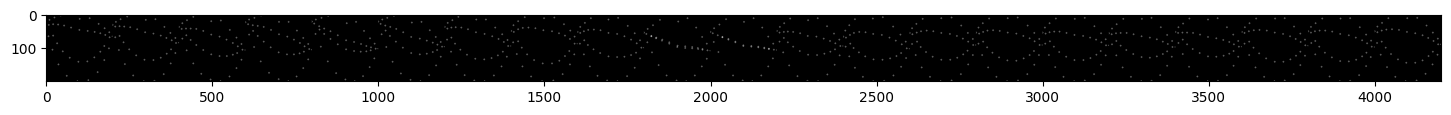

In [64]:
show_frames(frames=train_X_landmarks[0],landmark=True)
print(f"Class: {train_Y[0]}")

## Encode Labels

In [65]:
word_set = np.unique(train_Y)
word_set.sort()
word_set = [x.strip() for x in word_set]

temp_labels = np.concatenate((train_Y,test_Y,val_Y), axis=0)

class_count = {x:0 for x in word_set}
for x in temp_labels:
    class_count[x.strip()] += 1
print(class_count)

label_encoder = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=word_set,output_mode="one_hot"
)

num_words = len(label_encoder.get_vocabulary())
print(label_encoder.get_vocabulary())
print(label_encoder(label_encoder.get_vocabulary()))

{'ABOUT': 2192, 'BELIEVE': 2200, 'CHANCE': 2194, 'FAMILY': 2198, 'THROUGH': 2198}
['ABOUT', 'BELIEVE', 'CHANCE', 'FAMILY', 'THROUGH']
tf.Tensor(
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]], shape=(5, 5), dtype=float32)


In [66]:
def encode_labels(labels):
    data_Y = label_encoder(np.array([x.strip() for x in labels])).numpy()
    print(labels)
    print(data_Y)
    return data_Y

In [67]:
train_Y = encode_labels(labels=train_Y)
test_Y = encode_labels(labels=test_Y)
val_Y = encode_labels(labels=val_Y)

['FAMILY ', 'FAMILY ', 'THROUGH', 'THROUGH', 'FAMILY ', 'FAMILY ', 'THROUGH', 'THROUGH', 'FAMILY ', 'FAMILY ', 'FAMILY ', 'FAMILY ', 'CHANCE ', 'CHANCE ', 'FAMILY ', 'FAMILY ', 'THROUGH', 'THROUGH', 'BELIEVE', 'BELIEVE', 'BELIEVE', 'BELIEVE', 'CHANCE ', 'CHANCE ', 'BELIEVE', 'BELIEVE', 'CHANCE ', 'CHANCE ', 'ABOUT  ', 'ABOUT  ', 'BELIEVE', 'BELIEVE', 'FAMILY ', 'FAMILY ', 'ABOUT  ', 'ABOUT  ', 'FAMILY ', 'FAMILY ', 'THROUGH', 'THROUGH', 'THROUGH', 'THROUGH', 'CHANCE ', 'CHANCE ', 'ABOUT  ', 'ABOUT  ', 'THROUGH', 'THROUGH', 'FAMILY ', 'FAMILY ', 'THROUGH', 'THROUGH', 'ABOUT  ', 'ABOUT  ', 'FAMILY ', 'FAMILY ', 'ABOUT  ', 'ABOUT  ', 'FAMILY ', 'FAMILY ', 'ABOUT  ', 'ABOUT  ', 'THROUGH', 'THROUGH', 'BELIEVE', 'BELIEVE', 'CHANCE ', 'CHANCE ', 'FAMILY ', 'FAMILY ', 'THROUGH', 'THROUGH', 'BELIEVE', 'BELIEVE', 'FAMILY ', 'FAMILY ', 'ABOUT  ', 'ABOUT  ', 'ABOUT  ', 'ABOUT  ', 'FAMILY ', 'FAMILY ', 'THROUGH', 'THROUGH', 'THROUGH', 'THROUGH', 'THROUGH', 'THROUGH', 'ABOUT  ', 'ABOUT  ', 'BELIEVE'

# Model Training

## Learning Rate Scheduler

In [77]:
initial_lr = 0.0001
epochs = 100
batch_size: int = 32
decay_steps = int(len(train_Y)/batch_size)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(proj_model_dir, "best_run.hdf5"),
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr,decay_steps=decay_steps,decay_rate=0.95,staircase=False)

def scheduler(epoch, lr):
    if(epoch % 20 == 0):
        return lr * 0.5
    else:
        return lr
schedule_callback = LearningRateScheduler(scheduler)

## Model Architecture

Model is video based & word based. It uses feature vectors extracted for each frame.

In [78]:
show_data()

Train data frames length: (8786, 21, 2048)
Train data landmarks length: (8786, 21, 40, 3)
Train labels length: (8786, 5)
Test data frames length: (1098, 21, 2048)
Test data landmarks length: (1098, 21, 40, 3)
Test labels length: (1098, 5)
Validation data frames length: (1098, 21, 2048)
Validation data landmarks length: (1098, 21, 40, 3)
Validation labels length: (1098, 5)


In [79]:
if(model_type == COMBINED_MODEL):
    train_ds = tf.data.Dataset.from_tensor_slices(
      ((train_X_frames,train_X_landmarks), train_Y)
    )
    train_ds = train_ds.padded_batch(batch_size, padded_shapes=((np.shape(train_X_frames[0]),np.shape(train_X_landmarks[0])),np.shape(train_Y[0])))

    test_ds = tf.data.Dataset.from_tensor_slices(
      ((test_X_frames,test_X_landmarks), test_Y)
    )
    test_ds = test_ds.padded_batch(batch_size, padded_shapes=((np.shape(test_X_frames[0]),np.shape(test_X_landmarks[0])),np.shape(test_Y[0])))

    val_ds = tf.data.Dataset.from_tensor_slices(
      ((val_X_frames,val_X_landmarks), val_Y)
    )
    val_ds = val_ds.padded_batch(batch_size, padded_shapes=((np.shape(val_X_frames[0]),np.shape(val_X_landmarks[0])),np.shape(val_Y[0])))
elif(model_type == VISUAL_MODEL):
    train_ds = tf.data.Dataset.from_tensor_slices(
      (train_X_frames, train_Y)
    )
    train_ds = train_ds.padded_batch(batch_size, padded_shapes=(np.shape(train_X_frames[0]),np.shape(train_Y[0])))

    test_ds = tf.data.Dataset.from_tensor_slices(
      (test_X_frames, test_Y)
    )
    test_ds = test_ds.padded_batch(batch_size, padded_shapes=(np.shape(test_X_frames[0]),np.shape(test_Y[0])))

    val_ds = tf.data.Dataset.from_tensor_slices(
      (val_X_frames, val_Y)
    )
    val_ds = val_ds.padded_batch(batch_size, padded_shapes=(np.shape(val_X_frames[0]),np.shape(val_Y[0])))
elif(model_type == LANDMARK_MODEL):
    train_ds = tf.data.Dataset.from_tensor_slices(
      (train_X_landmarks, train_Y)
    )
    train_ds = train_ds.padded_batch(batch_size, padded_shapes=(np.shape(train_X_landmarks[0]),np.shape(train_Y[0])))

    test_ds = tf.data.Dataset.from_tensor_slices(
      (test_X_landmarks, test_Y)
    )
    test_ds = test_ds.padded_batch(batch_size, padded_shapes=(np.shape(test_X_landmarks[0]),np.shape(test_Y[0])))

    val_ds = tf.data.Dataset.from_tensor_slices(
      (val_X_landmarks, val_Y)
    )
    val_ds = val_ds.padded_batch(batch_size, padded_shapes=(np.shape(val_X_landmarks[0]),np.shape(val_Y[0])))
    
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [80]:
if(3 <= model_num <= 5):
    input_shape = np.shape(train_X_frames[0])
    if(model_num == 5):
        input_shape = np.shape(train_X_landmarks[0])
    model = Sequential([
       layers.InputLayer(input_shape= input_shape),
       layers.TimeDistributed(Flatten()),
       layers.Bidirectional(LSTM(128,activation='relu', return_sequences=True)),
       layers.Dropout(0.2),
       layers.Bidirectional(LSTM(128,activation='relu', return_sequences=True)),
       layers.Dropout(0.2),
       layers.Bidirectional(LSTM(128,activation='relu', return_sequences=False)),
       layers.Dense(64,activation='relu'),
       layers.Dropout(0.2),
       layers.Dense(32,activation='relu'),
       layers.Dropout(0.2),
       layers.Dense(16,activation='relu'),
       layers.Dropout(0.2),
       layers.Dense(num_words,activation='softmax')
    ])
elif(model_num == 8):
    # ## Both attention architecture
    epsilon = 1e-6
    d_model = 120
    dff = 120

    input_layer_frames = Input(shape= np.shape(train_X_frames[0]), name="input_frames")
    flatten_layer_frames = TimeDistributed(Flatten())(input_layer_frames)
    attention_layer_frames = Attention(use_scale=True)([flatten_layer_frames,flatten_layer_frames])
    norm_layer_frames = LayerNormalization(epsilon=epsilon)(flatten_layer_frames + attention_layer_frames)

    input_layer_landmarks = Input(shape= np.shape(train_X_landmarks[0]), name="input_landmarks")
    flatten_layer_landmarks = TimeDistributed(Flatten())(input_layer_landmarks)
    dense_scale_layer = Dense(np.shape(train_X_frames[0])[-1])(flatten_layer_landmarks)
    attention_layer_landmarks = Attention(use_scale=True)([dense_scale_layer,dense_scale_layer])
    norm_layer_landmarks = LayerNormalization(epsilon=epsilon)(dense_scale_layer + attention_layer_landmarks)

    cross_attention_layer1 = Attention(use_scale=True)([norm_layer_landmarks,norm_layer_frames])
    cross_norm_layer1 = LayerNormalization(epsilon=epsilon)(cross_attention_layer1 + norm_layer_landmarks + norm_layer_frames)

    cross_attention_layer2 = Attention(use_scale=True)([norm_layer_frames,norm_layer_landmarks])
    cross_norm_layer2 = LayerNormalization(epsilon=epsilon)(cross_attention_layer2 + norm_layer_landmarks + norm_layer_frames)

    concatenate_layer = Concatenate(axis=-1)([cross_norm_layer1,cross_norm_layer2])

    conv_layer1 = Conv1D(1024, 3, padding='same', activation='relu')(concatenate_layer)
    dropout1 = Dropout(0.1)(conv_layer1)
    max_pooling1 = MaxPooling1D()(dropout1)

    conv_layer2 = Conv1D(256, 3, padding='same', activation='relu')(max_pooling1)
    dropout2 = Dropout(0.1)(conv_layer2)
    max_pooling2 = MaxPooling1D()(dropout2)

    conv_layer3 = Conv1D(64, 3, padding='same', activation='relu')(max_pooling2)
    dropout3 = Dropout(0.1)(conv_layer3)
    max_pooling3 = MaxPooling1D()(dropout3)

    conv_layer4 = Conv1D(32, 3, padding='same', activation='relu')(max_pooling3)
    max_pooling4 = MaxPooling1D()(conv_layer4)

    flatten_layer_final = Flatten()(max_pooling4)

    output_layer = Dense(num_words,activation='softmax')(flatten_layer_final)


    model = Model(inputs=[input_layer_frames,input_layer_landmarks], outputs=output_layer)
elif(model_num == 7):
    #Transformer architecture
    sequence_length = len(train_X_landmarks[0])
    d_model = 120
    num_encoder_layers = 3
    num_heads = 3
    dff = 120
    epsilon = 1e-6

    input_layer = Input(shape= np.shape(train_X_landmarks[0]))
    flatten_layer1 = TimeDistributed(Flatten())(input_layer)

    positional_encoding = keras.layers.Embedding(
            input_dim=sequence_length, output_dim=d_model
        )(tf.range(start=0, limit=sequence_length, delta=1))

    add_layer = flatten_layer1 + positional_encoding

    for _ in range(num_encoder_layers):
        x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(add_layer, add_layer)
        x = LayerNormalization(epsilon=epsilon)(x + add_layer)

        ffn = keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])
        y = ffn(x)
        add_layer = LayerNormalization(epsilon=epsilon)(y + x)

    flatten_layer2 = Flatten()(x)
    output_layer = Dense(num_words, activation='softmax')(flatten_layer2)

    model = keras.Model(input_layer, output_layer)

In [81]:
model.compile(optimizer=Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.compile(optimizer=Adam(learning_rate=initial_lr),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

In [82]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_landmarks (InputLaye  [(None, 21, 40, 3)]          0         []                            
 r)                                                                                               
                                                                                                  
 time_distributed_4 (TimeDi  (None, 21, 120)              0         ['input_landmarks[0][0]']     
 stributed)                                                                                       
                                                                                                  
 input_frames (InputLayer)   [(None, 21, 2048)]           0         []                            
                                                                                            

 g1D)                                                                                             
                                                                                                  
 conv1d_6 (Conv1D)           (None, 5, 64)                49216     ['max_pooling1d_5[0][0]']     
                                                                                                  
 dropout_10 (Dropout)        (None, 5, 64)                0         ['conv1d_6[0][0]']            
                                                                                                  
 max_pooling1d_6 (MaxPoolin  (None, 2, 64)                0         ['dropout_10[0][0]']          
 g1D)                                                                                             
                                                                                                  
 conv1d_7 (Conv1D)           (None, 2, 32)                6176      ['max_pooling1d_6[0][0]']     
          

## Example Before Training

In [83]:
backward_word_translations = {tf.argmax(label_encoder(x).numpy()).numpy():x for x in word_set}
backward_word_translations
print(f"Translations: {backward_word_translations}")


test_sample_frame = train_X_frames[0]
test_sample_frame = tf.expand_dims(test_sample_frame, 0)
    
test_sample_landmarks = train_X_landmarks[0]
test_sample_landmarks = tf.expand_dims(test_sample_landmarks, 0)
if(model_type == COMBINED_MODEL):
    test_sample = [test_sample_frame, test_sample_landmarks]
elif(model_type == LANDMARK_MODEL):
    test_sample = test_sample_landmarks
elif(model_type == VISUAL_MODEL):
    test_sample = test_sample_frame

test_label = train_Y[0]

print(f"Model input shape: {model.input_shape}")
test_out = model.predict(test_sample)
predicted = tf.argmax(test_out,axis=1)

print(f"Predicted: {test_out}")
print(f"True: {test_label}")

print(f"Translated Predicted: {backward_word_translations[int(predicted[0])]}")
print(f"Translated True: {backward_word_translations[tf.argmax(test_label).numpy()]}")

Translations: {0: 'ABOUT', 1: 'BELIEVE', 2: 'CHANCE', 3: 'FAMILY', 4: 'THROUGH'}
Model input shape: [(None, 21, 2048), (None, 21, 40, 3)]
1/1 [==============================] - 0s 376ms/step
Predicted: [[0.04849991 0.615736   0.08135736 0.06328039 0.19112627]]
True: [0. 0. 0. 1. 0.]
Translated Predicted: BELIEVE
Translated True: FAMILY


## Training

In [84]:
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks=[model_checkpoint_callback]
)
# history = model.fit(
#   train_ds,
#   validation_data=test_ds,
#   epochs=epochs,
#   callbacks=[schedule_callback,model_checkpoint_callback]
# )

Epoch 1/100
275/275 [==============================] - 153s 545ms/step - loss: 1.5549 - accuracy: 0.3031 - val_loss: 1.4511 - val_accuracy: 0.3634
Epoch 2/100
275/275 [==============================] - 151s 551ms/step - loss: 1.3253 - accuracy: 0.4347 - val_loss: 1.2040 - val_accuracy: 0.5064
Epoch 3/100
275/275 [==============================] - 150s 545ms/step - loss: 1.1127 - accuracy: 0.5463 - val_loss: 1.0075 - val_accuracy: 0.6230
Epoch 4/100
275/275 [==============================] - 148s 539ms/step - loss: 0.9516 - accuracy: 0.6265 - val_loss: 0.8997 - val_accuracy: 0.6667
Epoch 5/100
275/275 [==============================] - 149s 540ms/step - loss: 0.8260 - accuracy: 0.6830 - val_loss: 0.7912 - val_accuracy: 0.6949
Epoch 6/100
275/275 [==============================] - 149s 541ms/step - loss: 0.7244 - accuracy: 0.7344 - val_loss: 0.6776 - val_accuracy: 0.7523
Epoch 7/100
275/275 [==============================] - 151s 548ms/step - loss: 0.6471 - accuracy: 0.7651 - val_loss: 0

KeyboardInterrupt: 

## Save Model

In [ ]:
# model.save(os.path.join(proj_model_dir, "newest_model.keras"))

model.save_weights(os.path.join(proj_model_dir, "newest_model.hdf5"))
model_architecture = model.to_json()
with open(os.path.join(proj_model_dir, "best_run.json"), "w") as f:
  f.write(json.dumps(model_architecture, indent=4))

# Metrics

## Display Metrics

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

plt.savefig(os.path.join(proj_model_dir, "51_newest_model_metrics.pdf"))

plt.show()

In [ ]:
# proj_model_dir = "../models/4th experiment/2"
# proj_model_dir = "../../proj_models/"

with open(os.path.join(proj_model_dir, "best_run.json"), "r") as f:
    model_architecture = json.loads(f.read())

best_model = keras.models.model_from_json(model_architecture)
best_model.load_weights(os.path.join(proj_model_dir, "best_run.hdf5"))
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
val_result = best_model.evaluate(val_ds)

loss = val_result[0]
accuracy = val_result[1]
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

In [ ]:
predictions = []
targets = []
for batch in val_ds:
    X, y = batch
    batch_predictions = best_model.predict(X)
    predicted = tf.argmax(batch_predictions,axis=1)
    
    batch_predictions = [word_set[index] for index in predicted]
    batch_targets = [word_set[index] for index in tf.argmax(y,axis=1)]
    
    predictions.extend(batch_predictions)
    targets.extend(batch_targets)

wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in range(0, len(predictions)):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)